In [39]:
import pennylane as qml
from pennylane.qnn import TorchLayer
import torch, torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np, random, math, time, functools
import pandas as pd

In [40]:
EMBED_MODE   = "amplitude"
n_inputs, n_hidden = 3, 4
n_qubits     = n_inputs + n_hidden
state_dim    = 2 ** n_qubits

n_layers_rec = 2
n_layers_out = 3
batch_size   = 32
seq_len      = 12
lr, epochs   = 0.005, 200
plot_every   = 20
SEED         = 42

In [41]:
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

In [42]:
dev_rec = qml.device("default.qubit", wires=n_qubits)
dev_out = qml.device("default.qubit", wires=n_hidden)

In [43]:
def single_qubit_state(theta):
    return torch.stack([torch.cos(theta/2), torch.sin(theta/2)])

def kron_n(states):
    return functools.reduce(torch.kron, states)

def encode_to_amplitude(flow, temp, conc):
    theta = torch.tensor([ flow        * math.pi/10,   # 0–10  ➜  0–π
                           (temp-20)  * math.pi/20,    # 20–40 ➜  0–π
                           (conc-30)  * math.pi/20 ])  # 30–40 ➜  0–π
    data_q   = [single_qubit_state(th) for th in theta]
    hidden_q = [torch.tensor([1.,0.])] * n_hidden      # |0⟩ ancillas
    vec = kron_n(data_q + hidden_q)
    return vec / vec.norm()                            # length-128, unit-norm

In [44]:
@qml.qnode(dev_rec, interface="torch")
def qrnn_cell(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=n_inputs + j)) for j in range(n_hidden)]

qrnn_layer = TorchLayer(
    qrnn_cell, weight_shapes={"weights": (n_layers_rec, n_qubits, 3)}
)
qrnn_layer.batch_execute = False

@qml.qnode(dev_out, interface="torch")
def qnn_readout(inputs, weights):
    for j in range(n_hidden):
        qml.RY(inputs[j], wires=j)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_hidden))
    return qml.expval(qml.PauliZ(wires=0))

qnn_out_layer = TorchLayer(
    qnn_readout, weight_shapes={"weights": (n_layers_out, n_hidden, 3)}
)
qnn_out_layer.batch_execute = False

In [45]:
# ── 3)  QRNN module ──────────────────────────────────────────────────────────
class FullyQuantumRNN(nn.Module):
    def __init__(self):
        super().__init__(); self.qrnn = qrnn_layer; self.qout = qnn_out_layer
    def forward(self, x_seq):                  # (T,B,128)
        B, h = x_seq.shape[1], torch.zeros(batch_size, n_hidden)
        for t in range(x_seq.shape[0]):
            h = torch.stack([self.qrnn(x_seq[t,b]) for b in range(B)])
        return torch.stack([self.qout(h[b]) for b in range(B)]).unsqueeze(1)

In [46]:
# ── 4)  Perfect efficiency curve ─────────────────────────────────────────────
def true_eff(flow, temp, conc):
    ridge = torch.exp(-0.5*(conc-35)**2)
    peak  = torch.exp(-0.3*(flow-4)**2 - 0.02*(temp-25)**2)
    return 0.95 * ridge * peak


In [47]:
# ── 5)  Deterministic, noise-free sequences ─────────────────────────────────
def pure_sequences(T, B):
    """
    Build a noise-free physics tensor (T, B, 3) and its matching
    quantum-amplitude tensor (T, B, 128).

    flow  : linear ramp 2→6 m³/s with time
    temp  : mild sinusoid around 25 °C
    conc  : fixed at 35 PSU (ridge)
    """
    flow0 = torch.linspace(2.0, 6.0, B)
    temp0 = torch.linspace(23.0, 27.0, B)
    conc0 = torch.full((B,), 35.0)

    phys = torch.zeros(T, B, 3)
    for t in range(T):
        phys[t, :, 0] = flow0 + 0.1 * t
        phys[t, :, 1] = temp0 + 0.2 * math.sin(0.25 * t)
        phys[t, :, 2] = conc0                               # always 35

    # build amplitude vectors (inner stack → B, outer → T)
    amp = torch.stack([
        torch.stack([encode_to_amplitude(*phys[t, b]) for b in range(B)])
        for t in range(T)
    ])                                                      # (T, B, 128)
    return amp, phys


# ── small preview helper ────────────────────────────────────────────────────
def _preview_last_step(phys_tensor):
    """Show the first 5 samples of the last time-step as a table."""
    last = phys_tensor[-1]                                  # (B,3)
    df = pd.DataFrame(last[:5].numpy(),
                      columns=["flow (m³/s)", "temp (°C)", "conc (PSU)"])
    print("\n▶︎ Preview of input features (last time-step, first 5 samples):")
    print(df.to_string(index=False))
    print()


# ── make_dataset  (returns *three* tensors) ─────────────────────────────────
def make_dataset():
    X_amp, phys = pure_sequences(seq_len, batch_size)

    # perfect efficiency for the last time-step
    last = phys[-1]                                         # (B,3)
    Y    = true_eff(last[:, 0], last[:, 1], last[:, 2]).unsqueeze(1)

    _preview_last_step(phys)                                # optional print

    # return amplitudes, targets, and raw physics
    return X_amp, Y, phys


In [48]:
# ── Visualise the raw physics data (last time-step) ──────────────────────────
def plot_last_step_features(phys_tensor):
    """
    Scatter: flow (x) vs. temperature (y)  for the last time-step.
    Colour shows sample index, concentration is fixed at 35 PSU.
    """
    last = phys_tensor[-1]                     # shape (B,3)
    flows = last[:, 0].numpy()
    temps = last[:, 1].numpy()

    plt.figure(figsize=(6,4))
    plt.scatter(flows, temps, c=np.arange(len(flows)),
                cmap="viridis", marker="o", edgecolor="k")
    plt.colorbar(label="sample index")
    plt.xlabel("Flow rate  (m³/s)")
    plt.ylabel("Temperature  (°C)")
    plt.title("Feature distribution – last time-step")
    plt.tight_layout()
    plt.show()


In [49]:
# ── 6)  Train & plot ─────────────────────────────────────────────────────────
def train():
    # ── unpack THREE outputs ──
    X_amp, Y, phys = make_dataset()     # ← phys kept for later plots

    model = FullyQuantumRNN()
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses  = []

    for epoch in range(1, epochs + 1):
        opt.zero_grad()
        loss = loss_fn(model(X_amp), Y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if epoch % plot_every == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | MSE = {loss.item():.6f}")

    plt.figure(); plt.plot(losses)
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.title("Training (pure quantum states)"); plt.tight_layout(); plt.show()

    # return BOTH the trained model and the physics tensor
    return model, phys

def overlay(model):
    flows = torch.linspace(0,10,120)[:,None]
    temps = torch.full_like(flows,25.); concs = torch.full_like(flows,35.)
    x = torch.stack([encode_to_amplitude(f,t,c)
                     for f,t,c in zip(flows,temps,concs)]).unsqueeze(0)
    with torch.no_grad():
        pred  = model(x).squeeze()
        truth = true_eff(flows.squeeze(),temps.squeeze(),concs.squeeze())
    plt.figure(figsize=(6,4))
    plt.plot(flows, truth, label="Perfect efficiency")
    plt.plot(flows, pred, "--", label="QRNN predicted")
    plt.xlabel("Flow rate (m³/s)"); plt.ylabel("Efficiency")
    plt.title("QRNN vs Perfect Curve (pure inputs)"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:

print("Training with *pure* quantum inputs …")
t0 = time.perf_counter()

net, phys = train()      # ← receive phys here
overlay(net)             # overlay() only needs the model

print(f"Finished in {time.perf_counter() - t0:.1f}s")

Training with *pure* quantum inputs …

▶︎ Preview of input features (last time-step, first 5 samples):
 flow (m³/s)  temp (°C)  conc (PSU)
    3.100000  23.076332        35.0
    3.229032  23.205364        35.0
    3.358065  23.334396        35.0
    3.487097  23.463428        35.0
    3.616129  23.592461        35.0

Epoch   1 | MSE = 1.090749
Epoch  20 | MSE = 0.465410
Epoch  40 | MSE = 0.151146
Epoch  60 | MSE = 0.098536
Epoch  80 | MSE = 0.094280
Epoch 100 | MSE = 0.089501
Epoch 120 | MSE = 0.082669
Epoch 140 | MSE = 0.074123
Epoch 160 | MSE = 0.065546


In [ ]:
from matplotlib import pyplot as plt, cm
plot_last_step_features(phys)


▶︎ Preview of input features (last time-step, first 5 samples):
 flow (m³/s)  temp (°C)  conc (PSU)
    3.100000  23.076332        35.0
    3.229032  23.205364        35.0
    3.358065  23.334396        35.0
    3.487097  23.463428        35.0
    3.616129  23.592461        35.0 

▶︎ Ket notation (first 3 samples of last time-step):

sample 0:  |ψ⟩ = (+0.8838|0⟩ + +0.4679|1⟩) ⊗ (+0.9710|0⟩ + +0.2393|1⟩) ⊗ (+0.9239|0⟩ + +0.3827|1⟩) ⊗ |0000⟩

sample 1:  |ψ⟩ = (+0.8741|0⟩ + +0.4857|1⟩) ⊗ (+0.9685|0⟩ + +0.2491|1⟩) ⊗ (+0.9239|0⟩ + +0.3827|1⟩) ⊗ |0000⟩

sample 2:  |ψ⟩ = (+0.8641|0⟩ + +0.5034|1⟩) ⊗ (+0.9659|0⟩ + +0.2589|1⟩) ⊗ (+0.9239|0⟩ + +0.3827|1⟩) ⊗ |0000⟩



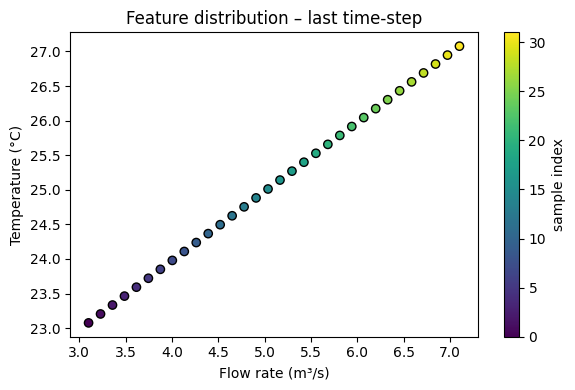

In [ ]:
#!/usr/bin/env python
"""
quantum_dataset_preview.py
--------------------------

Create the **pure, noise-free** quantum dataset that the QRNN would train on,
*without* running any training.  
The script

1. builds the classical feature tensor `phys`  (shape = T × B × 3),  
2. converts every triple into a **7-qubit product state** |ψ⟩, stored in
   `X_amp`  (shape = T × B × 128),  
3. prints a neat table of the last time-step’s first 5 samples, and  
4. prints the **ket-notation** for the first 3 samples so you can see the
   exact quantum states.

Adjust `seq_len`, `batch_size`, or the feature formulas as you wish.
"""

# ── Imports ──────────────────────────────────────────────────────────────────
import torch, math, functools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ── Parameters identical to the training script ─────────────────────────────
n_inputs, n_hidden = 3, 4
n_qubits           = n_inputs + n_hidden
state_dim          = 2 ** n_qubits
batch_size         = 32
seq_len            = 12

# ── Classical → quantum encoder (pure, unit-norm) ───────────────────────────
def single_qubit_state(theta: torch.Tensor) -> torch.Tensor:
    """Return cos(θ/2)|0⟩ + sin(θ/2)|1⟩  (real amplitudes)."""
    return torch.stack([torch.cos(theta/2), torch.sin(theta/2)])

def kron_n(states):
    vec = states[0]
    for s in states[1:]:
        vec = torch.kron(vec, s)
    return vec

def encode_to_amplitude(flow: float, temp: float, conc: float) -> torch.Tensor:
    """Map one (flow, temp, conc) triple to a 7-qubit product state vector."""
    theta = torch.tensor([
        flow       * math.pi/10,        #  0–10  ➜  0–π
        (temp-20) * math.pi/20,         # 20–40 ➜  0–π
        (conc-30) * math.pi/20          # 30–40 ➜  0–π
    ])
    data_q   = [single_qubit_state(th) for th in theta]    # 3 qubits
    hidden_q = [torch.tensor([1., 0.])] * n_hidden         # four |0⟩ qubits
    vec      = kron_n(data_q + hidden_q)
    return vec / vec.norm()                                # (128,)

# ── Build deterministic, noise-free sequences ───────────────────────────────
def pure_sequences(T=seq_len, B=batch_size):
    flow0 = torch.linspace(2.0, 6.0, B)
    temp0 = torch.linspace(23.0, 27.0, B)
    conc0 = torch.full((B,), 35.0)

    phys = torch.zeros(T, B, 3)
    for t in range(T):
        phys[t,:,0] = flow0 + 0.1 * t
        phys[t,:,1] = temp0 + 0.2 * math.sin(0.25 * t)
        phys[t,:,2] = conc0                       # fixed ridge at 35 PSU

    X_amp = torch.stack([
        torch.stack([encode_to_amplitude(*phys[t,b]) for b in range(B)])
        for t in range(T)
    ])                                           # (T, B, 128)
    return X_amp, phys

# ── Pretty-print helper for the last time-step ───────────────────────────────
def preview_last_step(phys_tensor):
    last = phys_tensor[-1]                       # (B,3)
    df = pd.DataFrame(last[:5].numpy(),
                      columns=["flow (m³/s)", "temp (°C)", "conc (PSU)"])
    print("\n▶︎ Preview of input features (last time-step, first 5 samples):")
    print(df.to_string(index=False), "\n")

# ── Ket-notation helper for human reading ───────────────────────────────────
def ket_notation(flow, temp, conc, dec=4) -> str:
    """Return the 7-qubit product state as a ket string."""
    θ = [
        math.pi * flow / 10,
        math.pi * (temp - 20) / 20,
        math.pi * (conc - 30) / 20
    ]
    fmt = lambda x: f"{x:+.{dec}f}"
    qubit = lambda th: f"({fmt(math.cos(th/2))}|0⟩ + {fmt(math.sin(th/2))}|1⟩)"
    return qubit(θ[0]) + " ⊗ " + qubit(θ[1]) + " ⊗ " + qubit(θ[2]) + " ⊗ |0000⟩"

# ── Main execution ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    # build data
    X_amp, phys = pure_sequences()

    # 1) table preview
    preview_last_step(phys)

    # 2) show ket notation for first 3 samples
    print("▶︎ Ket notation (first 3 samples of last time-step):\n")
    for idx in range(3):
        f, t, c = phys[-1, idx]
        print(f"sample {idx}:  |ψ⟩ = {ket_notation(float(f), float(t), float(c))}\n")

    # 3) optional scatter of flow vs temperature
    flows = phys[-1,:,0]; temps = phys[-1,:,1]
    plt.figure(figsize=(6,4))
    plt.scatter(flows, temps, c=np.arange(batch_size),
                cmap="viridis", edgecolors="k")
    plt.colorbar(label="sample index")
    plt.xlabel("Flow rate (m³/s)"); plt.ylabel("Temperature (°C)")
    plt.title("Feature distribution – last time-step")
    plt.tight_layout(); plt.show()

    # Data tensors available for export:
    #   • X_amp  – pure quantum amplitude vectors
    #   • phys   – classical features for every time-step